In [12]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
# Paths to the JSON files
file_paths = [
    r"C:\Users\PC\Downloads\json_thesis\mistral_events_openended_results_0_6006.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_events_openended_results_6007_13212.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_events_openended_results_13213_19818.json"
]

# Define keywords for location and year questions for each language
location_keywords = {
    'EN': ["In which country did the event"],
    'FR': ["Dans quel pays a eu lieu l'événement"],
    'DE': ["In welchem Land fand das Ereignis "],
    'TR': [" olayı hangi ülkede gerçekleşti"],
    'JA': ["はどの国で行われましたか"]
}

year_keywords = {
    'EN': ["In which year did the event"],
    'FR': ["En quelle année a eu lieu l'événement "],
    'DE': ["In welchem Jahr fand das Ereignis"],
    'TR': ["olayı hangi yıl gerçekleşti"],
    'JA': ["は何年に行われましたか"]
}

# Function to load JSON file and convert to DataFrame
def load_json_to_df(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df

# Function to flatten nested dictionary entries
def flatten_nested_entries(df):
    records = []
    for _, row in df.iterrows():
        num_entries = len(row['Question'])
        for i in range(num_entries):
            records.append({
                'Question': row['Question'].get(str(i), None),
                'Model_Answer': row['Model_Answer'].get(str(i), None),
                'Correct_Answer': row['Correct_Answer'].get(str(i), None),
                'Compared_Answer': row['Compared_answer'].get(str(i), None),
                'Language': row['Language'].get(str(i), None),
                'Time_Taken': row['Time_Taken'].get(str(i), None)
            })
    return pd.DataFrame(records)

# Function to classify question type based on keywords
def get_question_type(question, language):
    if language not in location_keywords or language not in year_keywords:
        return "Other"
    
    for keyword in location_keywords[language]:
        if keyword.lower() in question.lower():
            return "Location"
    for keyword in year_keywords[language]:
        if keyword.lower() in question.lower():
            return "Year"
    return "Other"

# Initialize a DataFrame to store combined data
combined_df = pd.DataFrame()

# Load data from the JSON files and flatten nested entries
for file_path in file_paths:
    df = load_json_to_df(file_path)
    flattened_df = flatten_nested_entries(df)
    combined_df = pd.concat([combined_df, flattened_df], ignore_index=True)

# Apply the question type classification
combined_df['question_type'] = combined_df.apply(lambda row: get_question_type(row['Question'], row['Language']), axis=1)


In [13]:
combined_df

,Question,Model_Answer,Correct_Answer,Compared_Answer,Language,Time_Taken,question_type
0,In which country did the event 'Battle of Whit...,The Battle of White Oak Swamp took place in th...,United States of America,1,EN,2.080400,Location
1,In which year did the event 'Battle of White O...,The Battle of White Oak Swamp occurred in the ...,1862.0,0,EN,1.061554,Year
2,Dans quel pays a eu lieu l'événement 'bataille...,The Battle of White Oak Swamp took place in th...,États-Unis,0,FR,1.340842,Location
3,En quelle année a eu lieu l'événement 'bataill...,I would be happy to help you with your questio...,1862.0,1,FR,2.108126,Year
4,In welchem Land fand das Ereignis 'Battle of W...,Answer: The Battle of White Oak Swamp took pla...,Vereinigte Staaten,0,DE,2.101519,Location
...,...,...,...,...,...,...,...
19811,In welchem Jahr fand das Ereignis 'Battle of S...,Answer: The Battle of South Mills took place i...,1862.0,0,DE,2.064611,Year
19812,'Battle of South Mills' olayı hangi ülkede ger...,"I'd be happy to help you with your question, b...",Amerika Birleşik Devletleri,0,TR,2.067550,Location
19813,'Battle of South Mills' olayı hangi yıl gerçek...,"I'd be happy to help you with your question, b...",1862.0,0,TR,2.071122,Year
19814,イベント'Battle of South Mills'はどの国で行われましたか？,The Battle of South Mills was fought in the Un...,アメリカ合衆国,0,JA,2.069046,Location


In [14]:
combined_df.to_csv('oe_events.csv', index=False)

In [8]:
# Function to extract 'Other' entries for inspection
def extract_other_entries(df, num_samples=10):
    other_df = df[df['question_type'] == 'Other']
    return other_df.sample(min(num_samples, len(other_df)), random_state=1)

# Extract 'Other' entries for inspection
other_entries = extract_other_entries(combined_df)

# Display the 'Other' entries
print("Entries classified as 'Other':")
print(other_entries)

# Display summary statistics by language
summary = combined_df.groupby(['Language', 'question_type']).size().unstack(fill_value=0)
print("Summary statistics by language:")
print(summary)

Entries classified as 'Other':
Empty DataFrame
Columns: [Question, Model_Answer, Correct_Answer, Compared_Answer, Language, Time_Taken, question_type]
Index: []
Summary statistics by language:
question_type  Location  Year
Language                     
DE                 1985  1985
EN                 1972  1972
FR                 1996  1997
JA                 1983  1983
TR                 1971  1972


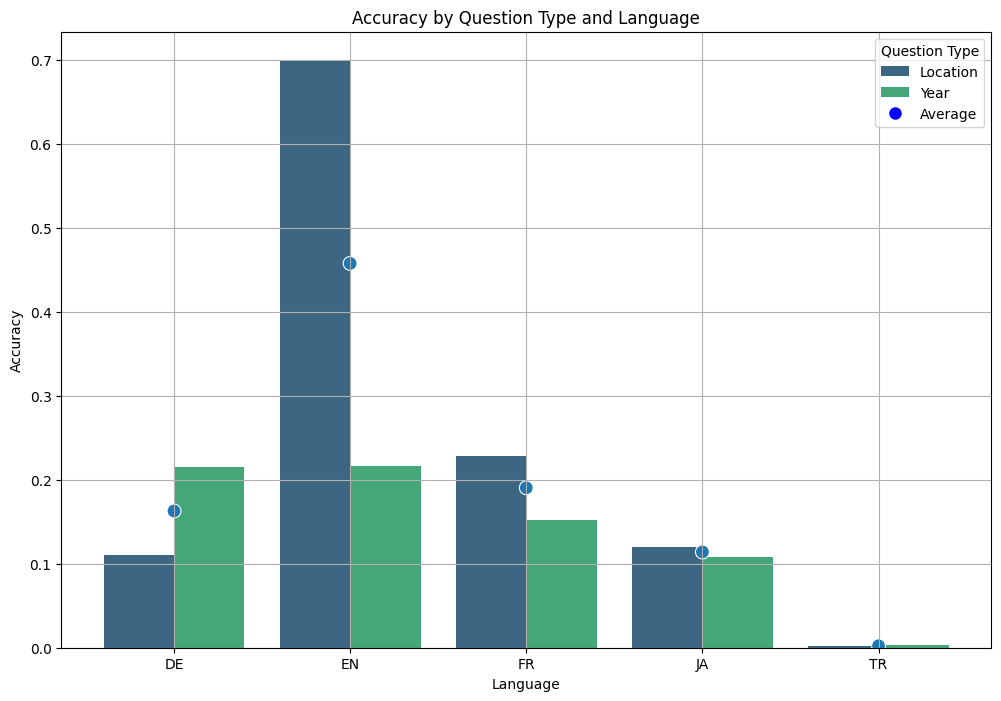

In [9]:
# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Location', 'Year'])]

# Calculate the average accuracy for each language
average_accuracy_df = filtered_accuracy_df.groupby('Language')['Accuracy'].mean().reset_index()
average_accuracy_df['question_type'] = 'Average'

# Combine the average accuracy with the filtered accuracy data
combined_accuracy_df = pd.concat([filtered_accuracy_df, average_accuracy_df], ignore_index=True)

# Plot the accuracies
plt.figure(figsize=(12, 8))

# Bar plot for Location and Year questions
sns.barplot(x='Language', y='Accuracy', hue='question_type', data=filtered_accuracy_df, palette='viridis')

# Scatter plot for Average accuracy
sns.scatterplot(x='Language', y='Accuracy', hue='question_type', style='question_type', data=average_accuracy_df, markers=['o'], s=100, color='blue', legend=False)

# Add a custom legend for the average dots
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Average', markersize=10, markerfacecolor='blue'))
labels.append('Average')

plt.legend(handles=handles, title='Question Type')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Type and Language')
plt.grid(True)
plt.show()

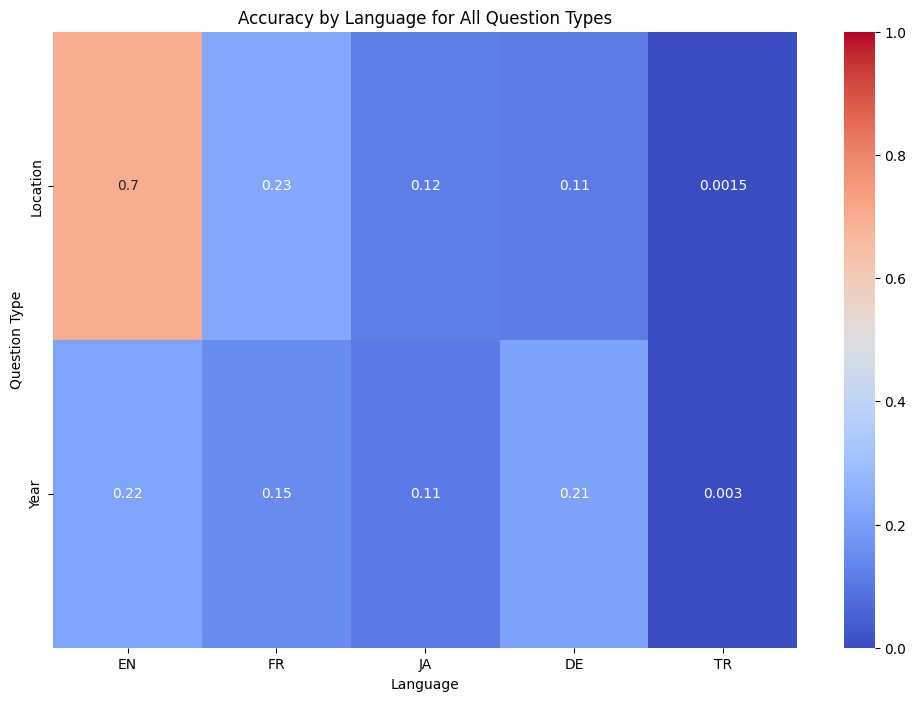

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order for groups and languages
language_order = ['EN', 'FR', 'JA', 'DE', 'TR']

# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['question_type', 'Language'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Location', 'Year'])]

# Create a pivot table for the heat map
pivot_df = filtered_accuracy_df.pivot_table(index='question_type', columns='Language', values='Accuracy')

# Reorder the languages in the pivot table
pivot_df = pivot_df[language_order]

# Plot a combined heatmap for all question types
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.xlabel('Language')
plt.ylabel('Question Type')
plt.title('Accuracy by Language for All Question Types')
plt.show()


In [17]:
# Filter the DataFrame for correct answers in Japanese with question type 'Location'
correct_answers_ja_location = combined_df[(combined_df['Compared_Answer'] == 1) & 
                                          (combined_df['Language'] == 'JA') & 
                                          (combined_df['question_type'] == 'Location')]

correct_answers_ja_location

,Question,Model_Answer,Correct_Answer,Compared_Answer,Language,Time_Taken,question_type
98,イベント'生野山の戦い'はどの国で行われましたか？,"Answer: 日本\n\nExplanation:\nThe event ""Genjō n...",日本,1,JA,2.094954,Location
128,イベント'First Battle of Boulou'はどの国で行われましたか？,Answer: フランス\n\nExplanation:\nThe First Battle...,フランス,1,JA,2.099530,Location
178,イベント'Battle of Saint-Pierre-d'Irube'はどの国で行われましたか？,Answer: フランス\n\nExplanation:\nThe Battle of Sa...,フランス,1,JA,2.134924,Location
218,イベント'サン・マロ襲撃'はどの国で行われましたか？,Answer: イベント'サン・マロ襲撃'はフランスで行われました。\n\nExplan,フランス,1,JA,2.127353,Location
530,イベント'明善寺合戦'はどの国で行われましたか？,Answer: 日本\n\nExplanation:\nThe event '明善寺合戦' ...,日本,1,JA,2.104031,Location
...,...,...,...,...,...,...,...
19184,イベント'摺上原の戦い'はどの国で行われましたか？,Answer: このイベントは日本で行われました。\n\n(Note: In this co...,日本,1,JA,2.102060,Location
19474,イベント'第二次小豆坂の戦い'はどの国で行われましたか？,Answer: 日本\n\nExplanation:\nThe event 'Second ...,日本,1,JA,1.853103,Location
19514,イベント'Battle of Martinique'はどの国で行われましたか？,Answer: フランス\n\nExplanation:\nThe Battle of Ma...,フランス,1,JA,2.079914,Location
19524,イベント'道明寺の戦い'はどの国で行われましたか？,Answer: 日本\n\nExplanation:\nThis event is call...,日本,1,JA,2.071342,Location


In [19]:
# Filter the DataFrame for correct answers in Japanese with question type 'Location'
correct_answers_tr_location = combined_df[(combined_df['Compared_Answer'] == 1) & 
                                          (combined_df['Language'] == 'TR')]

correct_answers_tr_location

,Question,Model_Answer,Correct_Answer,Compared_Answer,Language,Time_Taken,question_type
1481,'Mobile Bay Muharebesi' olayı hangi yıl gerçek...,I'd be happy to help answer your question in E...,1864.0,1,TR,2.078407,Year
6217,'Ishiyama Hongan-ji War' olayı hangi ülkede ge...,"Işiyama Hongan-ji War, 1570 yılında Japonya'da...",Japonya,1,TR,2.103031,Location
6442,'Castillon Muharebesi' olayı hangi yıl gerçekl...,I'd be happy to help answer your question in E...,1453.0,1,TR,2.084330,Year
12156,'2008 Turkish coup d'état attempt' olayı hangi...,I'm sorry for the confusion. The question is a...,2008.0,1,TR,2.026471,Year
13215,'Jena-Auerstedt Muharebesi' olayı hangi yıl ge...,I'd be happy to help you with your question in...,1806.0,1,TR,2.156471,Year
13457,'Battle of Ridgefield' olayı hangi yıl gerçekl...,I'd be happy to help answer your question in E...,1777.0,1,TR,2.125682,Year
15124,'I. Marne Muharebesi' olayı hangi ülkede gerçe...,I. Marne Battle took place in France.\n\n'I. M...,Fransa,1,TR,2.073693,Location
15346,'Izurusan Incident' olayı hangi ülkede gerçekl...,"Izurusan Incident, Japonya'da gerçekleştirilmi...",Japonya,1,TR,2.075873,Location
18019,'Alamo Muharebesi' olayı hangi yıl gerçekleşti?,I'd be happy to help answer your question in E...,1836.0,1,TR,2.084507,Year


In [20]:
# Display the Model_Answer column
print(correct_answers_tr_location['Model_Answer'])


1481     I'd be happy to help answer your question in E...
6217     Işiyama Hongan-ji War, 1570 yılında Japonya'da...
6442     I'd be happy to help answer your question in E...
12156    I'm sorry for the confusion. The question is a...
13215    I'd be happy to help you with your question in...
13457    I'd be happy to help answer your question in E...
15124    I. Marne Battle took place in France.\n\n'I. M...
15346    Izurusan Incident, Japonya'da gerçekleştirilmi...
18019    I'd be happy to help answer your question in E...
Name: Model_Answer, dtype: object


In [ ]:
#Now we look at the japanese scores

In [26]:
# Access and print the Model_Answer for the specified row
model_answer = correct_answers_tr_location.iloc[-2]['Model_Answer']
print(model_answer)


Izurusan Incident, Japonya'da gerçekleştirilmiştir. Bu olay, İzuru Şahad
